In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split
#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

In [2]:
data_df = pd.read_csv("creditcard.csv")

In [3]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


In [4]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,Amount,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

In [6]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

In [7]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


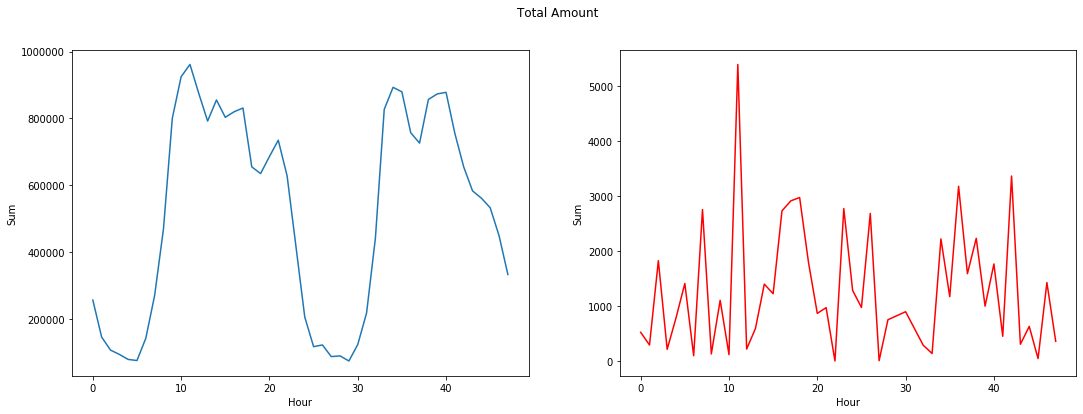

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

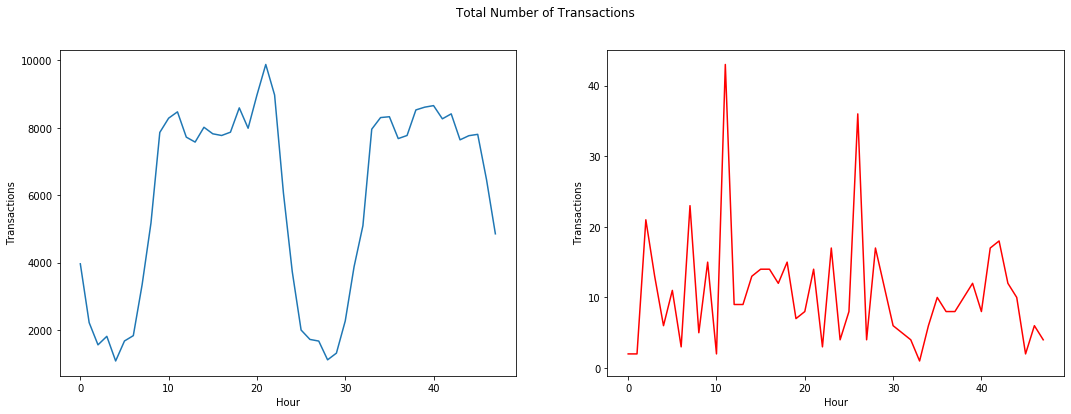

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

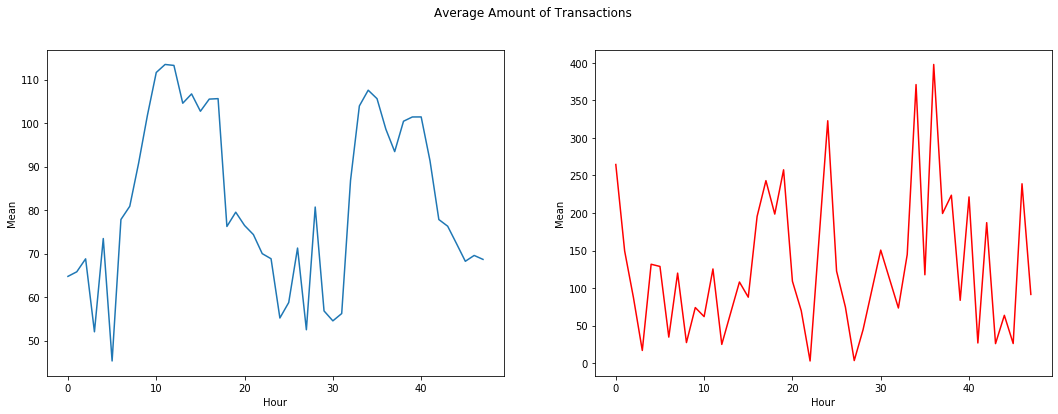

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

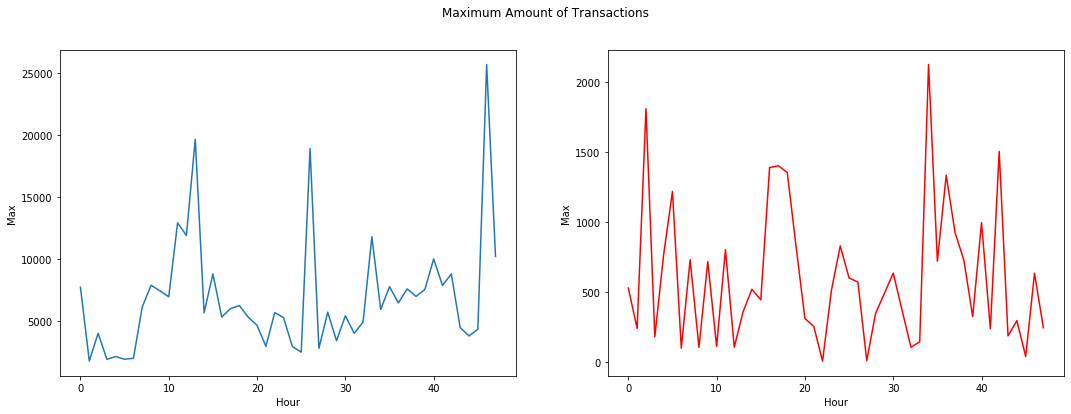

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

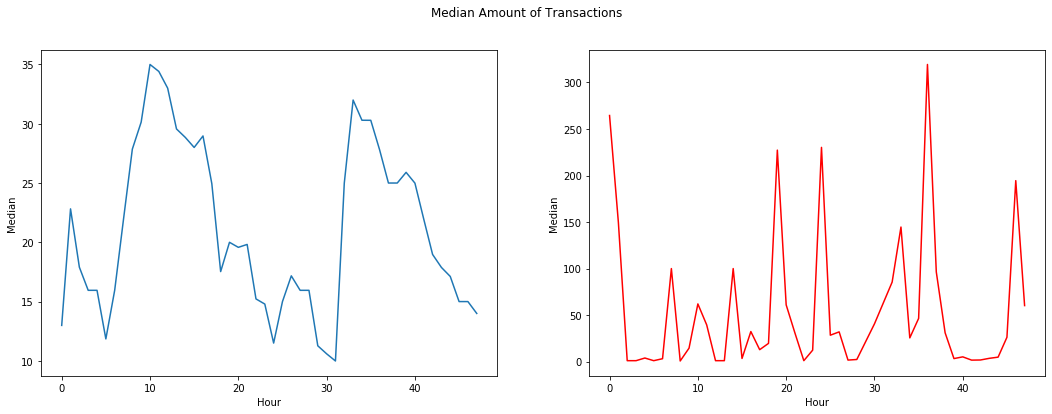

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

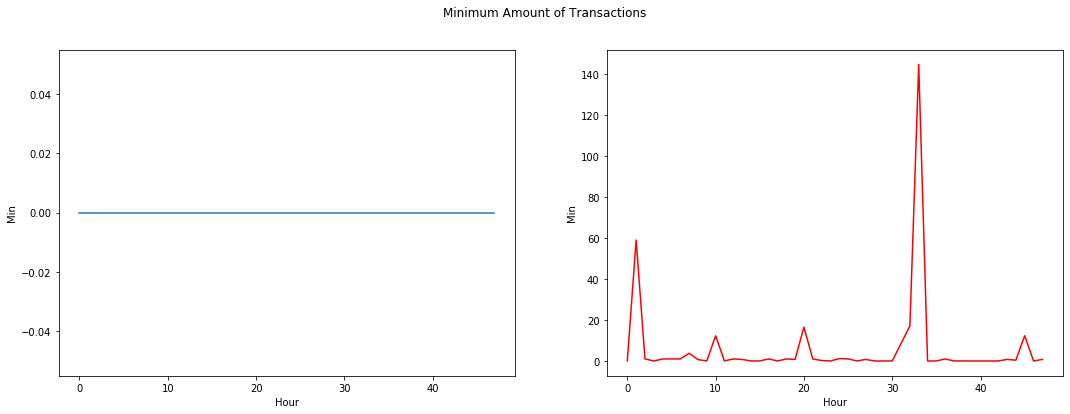

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

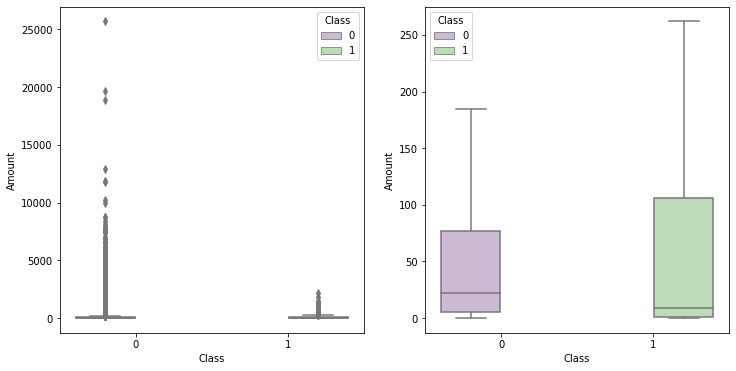

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [15]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [16]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
                      )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

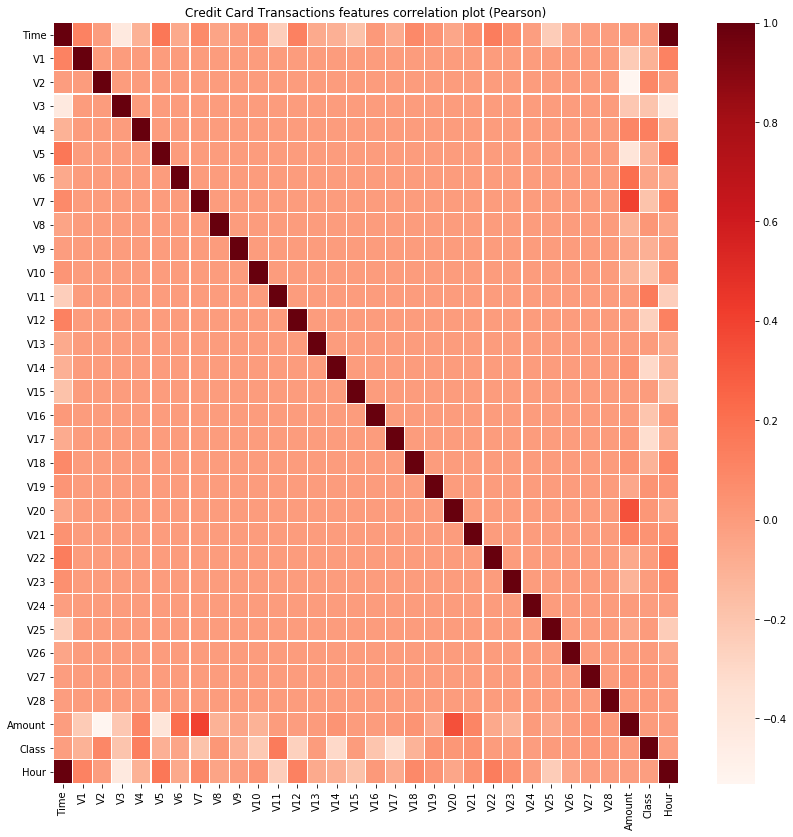

In [17]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

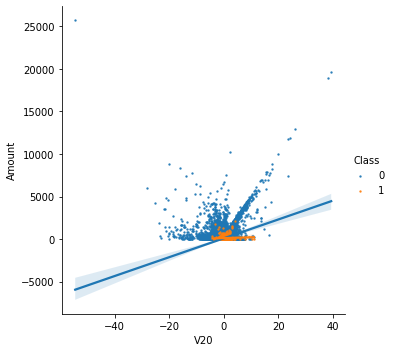

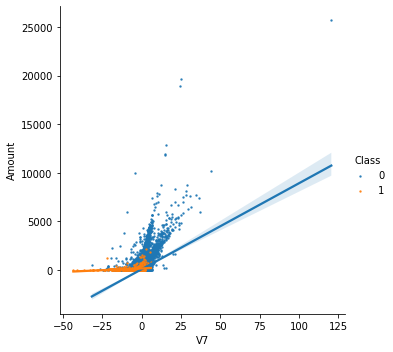

In [18]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

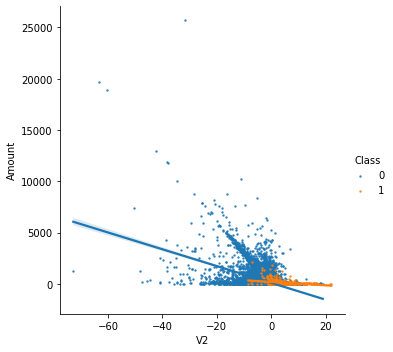

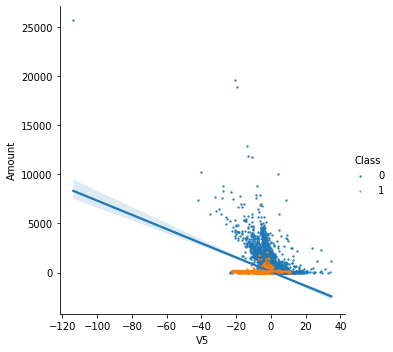

In [19]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

C:\Users\shubh\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning:

Data must have variance to compute a kernel density estimate.

C:\Users\shubh\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning:

Data must have variance to compute a kernel density estimate.



<Figure size 432x288 with 0 Axes>

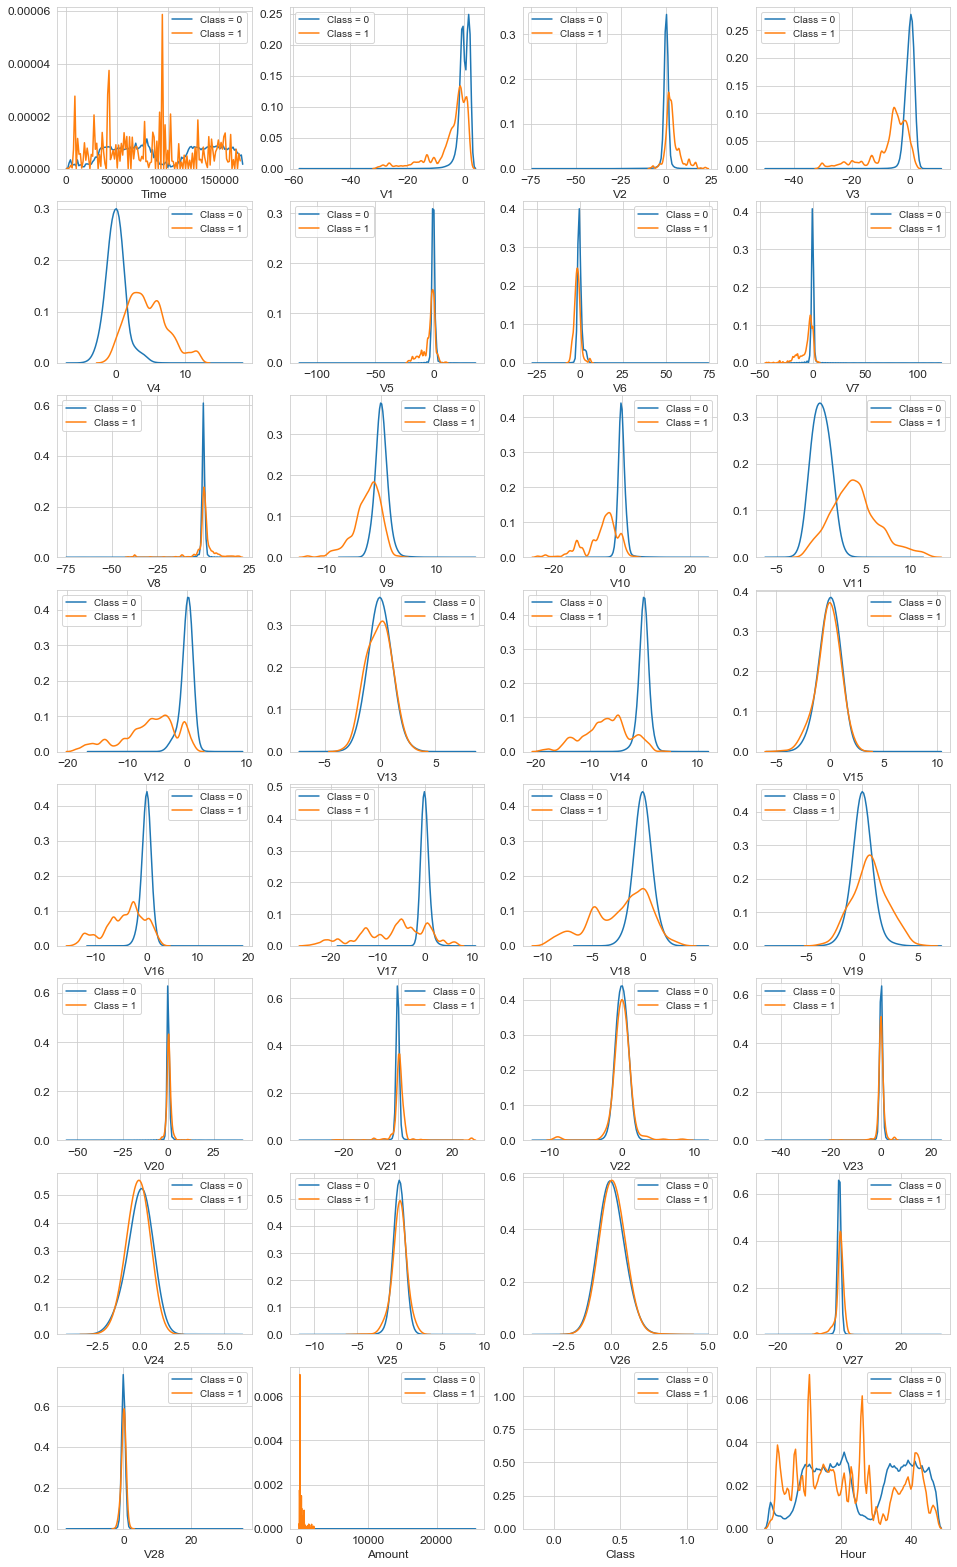

In [20]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [21]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [22]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [23]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [24]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=2018, verbose=False,
                       warm_start=False)

In [25]:
preds = clf.predict(valid_df[predictors])

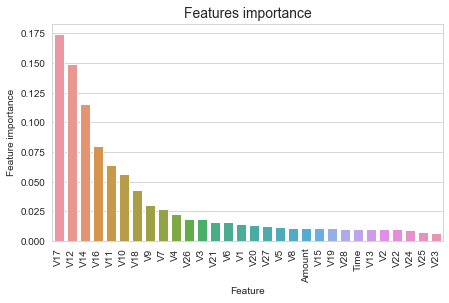

In [26]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

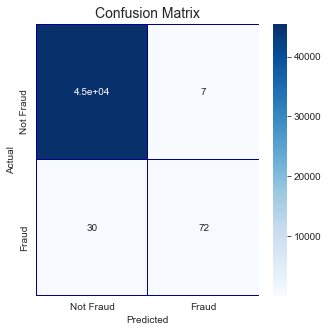

In [27]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [28]:
roc_auc_score(valid_df[target].values, preds)

0.8528641975628091

In [29]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [30]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=2018)

In [31]:
preds = clf.predict(valid_df[predictors])

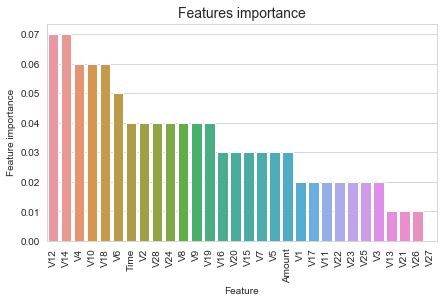

In [32]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

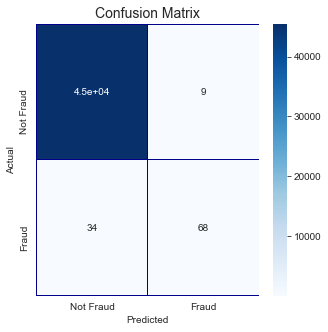

In [33]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [34]:
roc_auc_score(valid_df[target].values, preds)

0.8332343604519027

In [35]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [ ]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 2.79s	remaining: 23m 14s
50:	total: 2m 3s	remaining: 18m 4s
100:	total: 3m 49s	remaining: 15m 6s
150:	total: 5m 19s	remaining: 12m 19s
200:	total: 6m 41s	remaining: 9m 57s
250:	total: 8m	remaining: 7m 56s


In [ ]:
preds = clf.predict(valid_df[predictors])

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
roc_auc_score(valid_df[target].values, preds)

In [ ]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [ ]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [ ]:
preds = model.predict(dtest)

In [ ]:
roc_auc_score(test_df[target].values, preds)

In [ ]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
              'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [ ]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [ ]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=2*EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

In [ ]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

In [ ]:
preds = model.predict(test_df[predictors])

In [ ]:
roc_auc_score(test_df[target].values, preds)

In [ ]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
         num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= VERBOSE_EVAL, early_stopping_rounds= EARLY_STOP)
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)

In [ ]:
pred = test_preds